In [25]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns
from collections import defaultdict
import os
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from scipy.stats import spearmanr


sns.set_theme(style="whitegrid", context="paper")
sns.set_palette("coolwarm")
rs = check_random_state(42)

In [26]:
# Read data from CSV
# Fama french factors used for the model
data_fama_french = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)
data_fama_french_momentum = pd.read_csv("data/F-F_Momentum_Factor.CSV", skiprows=13)
data_fama_french_industry_portfolios = pd.read_csv(
    "data/10_Industry_Portfolios.CSV", skiprows=11
)  # value weighted portfolios
data_fama_french_100_portfolios = pd.read_csv(
    "data/100_Portfolios_10x10.CSV", skiprows=15
)  # value weighted

# FRED recession dates for graphing
fred_recessions = pd.read_csv("data/fred_recession_cycles.csv")

In [27]:
# Format the data in the dataframes to be consistent for further operations
data_fama_french["Date"] = pd.to_datetime(data_fama_french["Date"], format="%Y%m")
data_fama_french = data_fama_french.set_index("Date")

data_fama_french_momentum["Date"] = pd.to_datetime(
    data_fama_french_momentum["Date"], format="%Y%m"
)
data_fama_french_momentum = data_fama_french_momentum.set_index("Date")

data_fama_french_industry_portfolios["Date"] = pd.to_datetime(
    data_fama_french_industry_portfolios["Date"], format="%Y%m"
)
data_fama_french_industry_portfolios = data_fama_french_industry_portfolios.set_index(
    "Date"
)

data_fama_french_100_portfolios["Date"] = pd.to_datetime(
    data_fama_french_100_portfolios["Date"], format="%Y%m"
)
data_fama_french_100_portfolios = data_fama_french_100_portfolios.set_index(
    "Date"
)
data_fama_french_100_portfolios = data_fama_french_100_portfolios.loc[data_fama_french.index[0]:]

fred_recessions["Peak"] = pd.to_datetime(fred_recessions["Peak"], format="%Y-%m-%d")
fred_recessions["Trough"] = pd.to_datetime(fred_recessions["Trough"], format="%Y-%m-%d")

# leaving the data in percentage format to reduce float precision errors when fitting the HMM model

In [28]:
# Basic function to plot cumulative returns
def plot_cumulative_returns(returns, title="Cumulative Returns"):
    cumulative = (1 + returns).cumprod()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=cumulative, linewidth=2, palette="gist_earth" if cumulative.ndim == 2 else None)
    plt.title(title)
    plt.xlabel("Godina" if isinstance(cumulative.index, pd.DatetimeIndex) else "Period")
    plt.ylabel("Kumulativni povrat")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

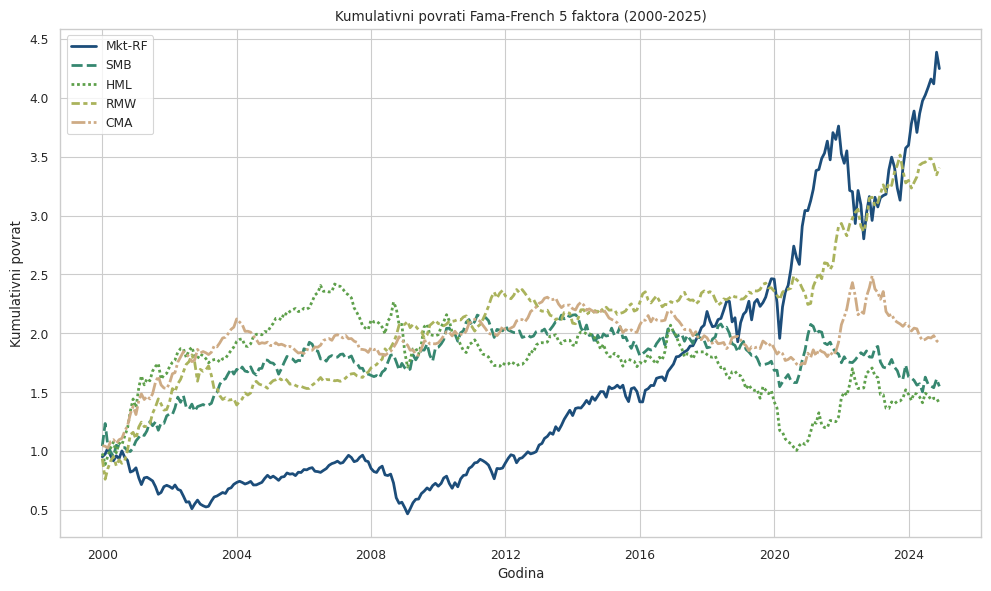

In [29]:
# Plot cumulative returns of the 5 factors
plot_cumulative_returns(
    data_fama_french.loc["2000-01-01":,["Mkt-RF", "SMB", "HML", "RMW", "CMA"]] / 100,
    title="Kumulativni povrati Fama-French 5 faktora (2000-2025)",
)

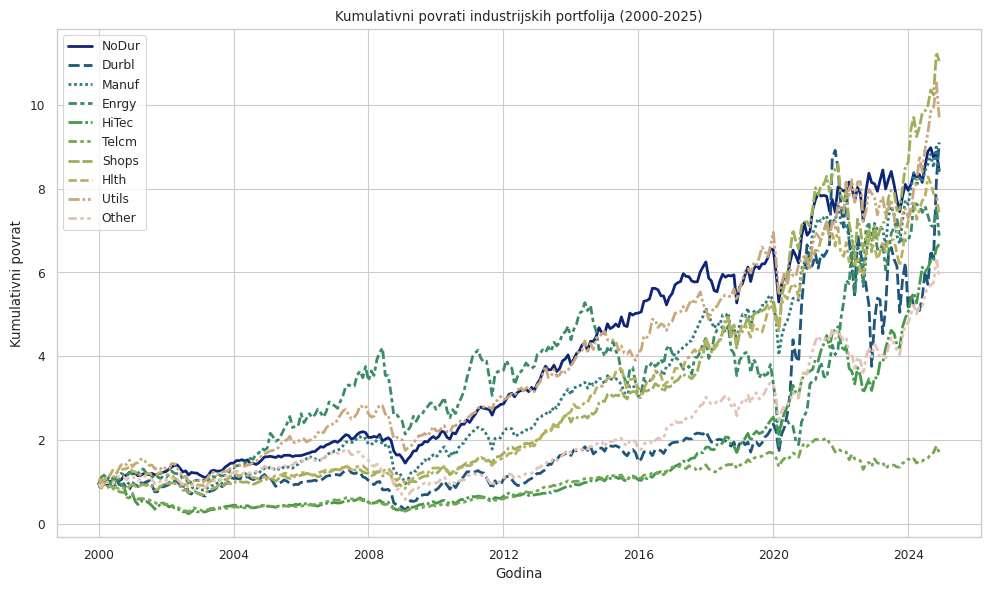

In [30]:
# Cumulative returns of industry portfolios
plot_cumulative_returns(
    data_fama_french_industry_portfolios[
        [
            "NoDur",
            "Durbl",
            "Manuf",
            "Enrgy",
            "HiTec",
            "Telcm",
            "Shops",
            "Hlth",
            "Utils",
            "Other",
        ]
    ].loc["2000-01-01":]
    / 100,
    title="Kumulativni povrati industrijskih portfolija (2000-2025)",
)

Nauči model na svih 6 parametara iz Fama-French podataka po cijeloj povijesti.
Vidi jesu li bolja 2, 3 ili 4 stanja
Full covar
GaussianHMM

In [31]:
model_parameters_df = pd.concat(
    [data_fama_french, data_fama_french_momentum, data_fama_french_industry_portfolios],
    axis=1,
).dropna()
model_parameters_df = model_parameters_df.drop(columns=["RF"]) # Leave out risk-free rate because MVO breaks with it, it is already included in Mkt-RF
model_parameters_df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.90,-0.48,-0.07,-1.39,2.30,-0.68,-0.25,-1.05,0.57,0.81,-1.59
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,1.01,4.87,6.54,6.19,3.94,5.13,4.28,6.42,9.56,4.20,5.44
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.19,-1.69,-0.25,-0.78,-3.65,0.14,2.36,0.93,-4.07,-2.50,-3.18
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,3.12,2.66,10.71,2.54,-0.33,8.30,3.43,0.51,3.38,-0.67,1.39
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,-0.74,-1.12,-5.17,0.30,-1.15,-0.29,4.14,-1.25,-1.65,-1.02,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,1.61,-3.65,-1.13,0.85,0.86,4.79,4.11,-5.16,1.79,-2.92,1.35,1.21,1.35,6.44,4.55,3.03
2024-09-01,1.74,-1.02,-2.59,0.04,-0.26,-0.60,0.99,14.24,2.83,-3.17,2.96,5.63,3.67,-1.81,5.35,0.66
2024-10-01,-0.97,-0.88,0.89,-1.38,1.03,2.87,-2.59,-3.14,-3.60,-0.54,-0.21,2.36,-1.14,-3.11,0.71,1.11


In [32]:
def evaluate_hmm(model_parameters_df, rs, ns, loop):
    """
    Evaluate HMM models with different numbers of states to find the ones with the best LL, AIC and BIC scores.
    Parameters:
        model_parameters_df (pd.DataFrame): DataFrame containing the model parameters.
        rs (int): Random state for reproducibility.
        ns (list): List of numbers of states to evaluate.
        loop (int): Number of iterations for each number of states.
    Returns:
        tuple: A tuple containing lists of AIC, BIC, LL scores, convergence status, iterations,
               best models, and all models for each number of states.
    """
    aic = []
    bic = []
    lls = []
    convergence_status = []
    iterations = []
    models = defaultdict(list)
    # saved in this format: {number_of_states: [(model, LL), ...]}
    best_models = defaultdict()

    X = model_parameters_df.values
    lengths = [len(X)]

    for n in ns:
        best_ll = None
        best_model = None
        for _ in range(loop):
            h = GaussianHMM(
                n,
                n_iter=2000,
                tol=1e-6,
                random_state=rs,
                covariance_type="full",
                verbose=False,
            )
            h.fit(X, lengths)
            score = h.score(X, lengths)
            models[n].append((h, score))
            if not best_ll or best_ll < score:
                best_ll = score
                best_model = h

        best_models[n] = best_model
        aic.append(best_model.aic(X))
        bic.append(best_model.bic(X))
        lls.append(best_model.score(X))
        convergence_status.append(best_model.monitor_.converged)
        iterations.append(best_model.monitor_.iter)

    # Log to make sure the results converge
    print("Convergence Status: ", convergence_status)
    print("Iterations: ", iterations)
    return aic, bic, lls, convergence_status, iterations, best_models, models

In [33]:
def plot_selection(ns, aic, bic, lls):
    """
    Plot AIC, BIC, and LL scores for model selection.
    Parameters:
        ns (list): List of numbers of states.
        aic (list): List of AIC scores.
        bic (list): List of BIC scores.
        lls (list): List of log-likelihood scores.
    Returns:
        None
    """
    fig, ax = plt.subplots()
    ax.plot(ns, aic, label="AIC", color="blue", marker="o")
    ax.plot(ns, bic, label="BIC", color="green", marker="o")
    ax2 = ax.twinx()
    ax2.plot(ns, lls, label="LL", color="orange", marker="o")
    ax.legend(handles=ax.lines + ax2.lines)
    ax.set_title("Evaluacija HMM koristeći AIC/BIC i LL")
    ax.set_ylabel("Informacijski kriterij (niže je bolje)")
    ax2.set_ylabel("Log izvjesnost (više je bolje)")
    ax.set_xlabel("Broj skrivenih stanja")
    fig.tight_layout()
    plt.show()


In [34]:
def plot_ll_histograms(models):
    """
    Plot histograms of log-likelihood scores for each number of states.
    Parameters:
        models (dict): Dictionary containing models and their log-likelihood scores.
    Returns:
        None
    """
    ns = sorted(models.keys())
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, n_components in enumerate(ns):
        component_scores = [score for (_, score) in models[n_components]]

        axes[idx].hist(
            component_scores, bins=25, edgecolor="k", alpha=0.65, density=True
        )

        axes[idx].set_title(
            f"{n_components} skrivena stanja\n(n={len(component_scores)})", pad=12
        )
        axes[idx].set_xlabel("Log izvjesnost", labelpad=8)
        axes[idx].set_ylabel("Gustoća", labelpad=8)
        axes[idx].grid(True, linestyle="--", alpha=0.6)

        mean_ll = np.mean(component_scores)
        axes[idx].axvline(
            mean_ll,
            color="r",
            linestyle="--",
            linewidth=1.5,
            label=f"Projsek: {mean_ll:.1f}",
        )
        axes[idx].legend()

    plt.tight_layout(pad=2.0)
    plt.show()

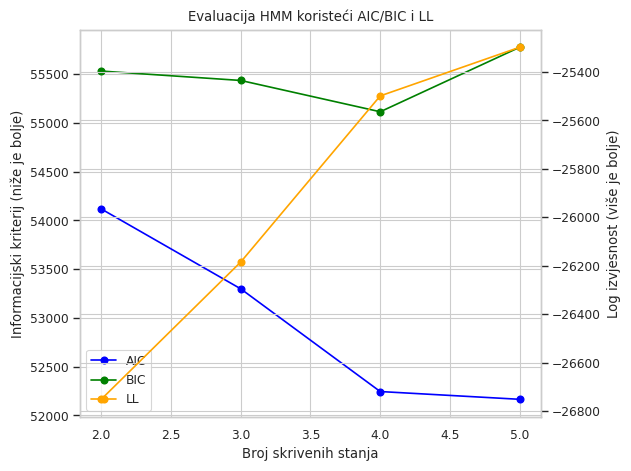

In [35]:
%%capture --no-display

aic, bic, lls, convergence_status, iterations, best_models, models = evaluate_hmm(
    model_parameters_df, rs, [2, 3, 4, 5], loop=200
)
plot_selection([2, 3, 4, 5], aic, bic, lls)

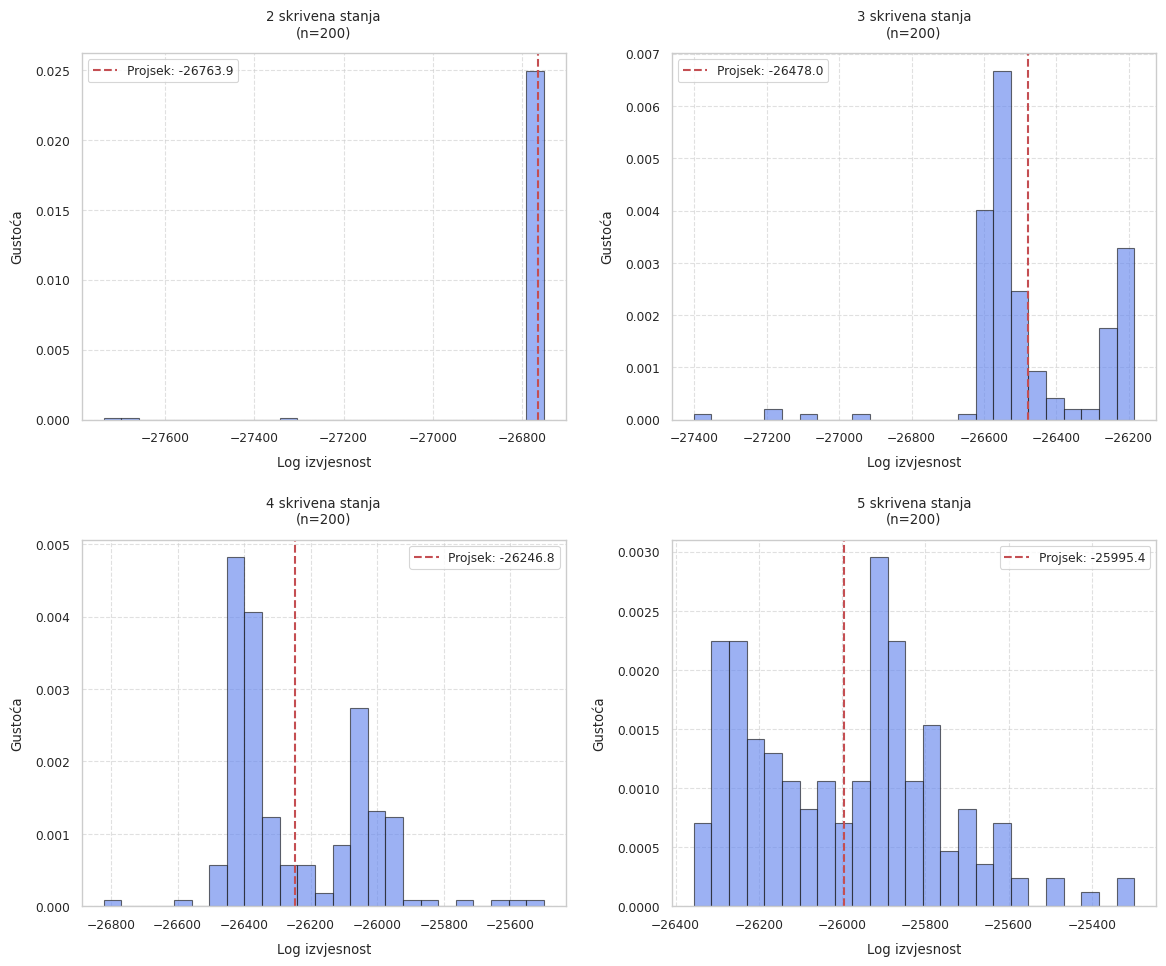

In [36]:
plot_ll_histograms(models)

Provedimo detaljnu analizu za modele s 2, 3 i 4 stanja. Grafovi će biti spremljeni u poseban direktorij.

In [37]:
# Whole timeframe of model parameters to train on, later will split into train/test sets
X = model_parameters_df.values
lengths = [len(X)]

# Extract the models with the best LL, AIC, and BIC scores for 2/3/4 states
model_2_states = best_models[2]

model_3_states = best_models[3]

model_4_states = best_models[4]

In [38]:
# Get probabilities of being in each state for each observation in the dataset
state_probs_2 = model_2_states.predict_proba(X, lengths=len(X))
state_probs_3 = model_3_states.predict_proba(X, lengths=len(X))
state_probs_4 = model_4_states.predict_proba(X, lengths=len(X))

In [39]:
def plot_single_ax(
    state_probs, 
    time_index, 
    n_regimes, 
    fred_recessions=None, 
    title="Estimated Regime Probabilities",
    ax=None
):
    """
    Plot the estimated regime probabilities from the HMM model.

    Parameters:
        state_probs (np.ndarray): Array of state probabilities.
        time_index (pd.DatetimeIndex): Time index for the x-axis.
        n_regimes (int): Number of regimes (states) in the model.
        fred_recessions (pd.DataFrame, optional): DataFrame containing FRED recession dates.
        title (str, optional): Title of the plot.
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If None, a new figure and axes are created.
        
    Returns:
        ax (matplotlib.axes.Axes): The axes with the plot.
    """
    line_styles = ["-", "--", ":", "-."]
    colors = ["black", "crimson", "gold", "pink"]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3))
    for j in range(n_regimes):
        sns.lineplot(
            x=time_index,
            y=state_probs[:, j],
            linestyle=line_styles[j % len(line_styles)],
            color=colors[j % len(colors)],
            linewidth=1.1,
            label=f"Režim {j+1}",
            ax=ax
        )
    ax.set_ylim(-0.05, 1.19)
    ax.set_ylabel("Vjerojatnost", fontsize=10)
    ax.set_xlim(time_index[0], time_index[-1])
    ax.axhline(y=0, color="black", linestyle="-", alpha=0.2)
    ax.axhline(y=1, color="black", linestyle="-", alpha=0.2)
    if fred_recessions is not None:
        for _, row in fred_recessions.iterrows():
            ax.axvspan(row["Peak"], row["Trough"], color="gray", alpha=0.25, zorder=0)
    ax.legend(loc="upper right", ncol=n_regimes, frameon=True, fontsize="small")
    ax.set_title(title, fontsize=11)
    sns.despine(ax=ax)
    return ax


In [40]:
def plot_regime_switches(model_parameters_df, state_probs_list, fred_recessions):
    """
    Plot regime switches for 2, 3, and 4 state HMMs with FRED recession dates shaded gray.

    Parameters:
        model_parameters_df (pd.DataFrame): DataFrame containing the model parameters.
        state_probs_list (list): List of state probabilities for each number of states.
        fred_recessions (pd.DataFrame): DataFrame containing FRED recession dates.
    Returns:
        None
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.text(
        0.5,
        0.95,
        "Vjerojatnosti promjene režima za (a) dva, (b) tri i (c) 4 skrivena stanja.",
        ha="center",
        fontsize=11,
    )

    titles = ["(a)", "(b)", "(c)"]
    n_regimes = [2, 3, 4]
    year_ticks = pd.date_range(
        start=model_parameters_df.index[0], end=model_parameters_df.index[-1], freq="5YS"
    )
    for i, (ax, prob, n_regime) in enumerate(zip(axes, state_probs_list, n_regimes)):
        plot_single_ax(
            state_probs=prob,
            time_index=model_parameters_df.index,
            n_regimes=n_regime,
            fred_recessions=fred_recessions,
            title=titles[i],
            ax=ax
        )
        ax.set_xticks(year_ticks)
        ax.set_xticklabels([f"1. siječnja \n{date.year}" for date in year_ticks])
        ax.set_xlabel("Datum")
        ax.tick_params(axis='x', labelbottom=True)

    for ax in axes:
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
        ax.spines["top"].set_linewidth(0.5)
        ax.spines["right"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.4)
    plt.show()


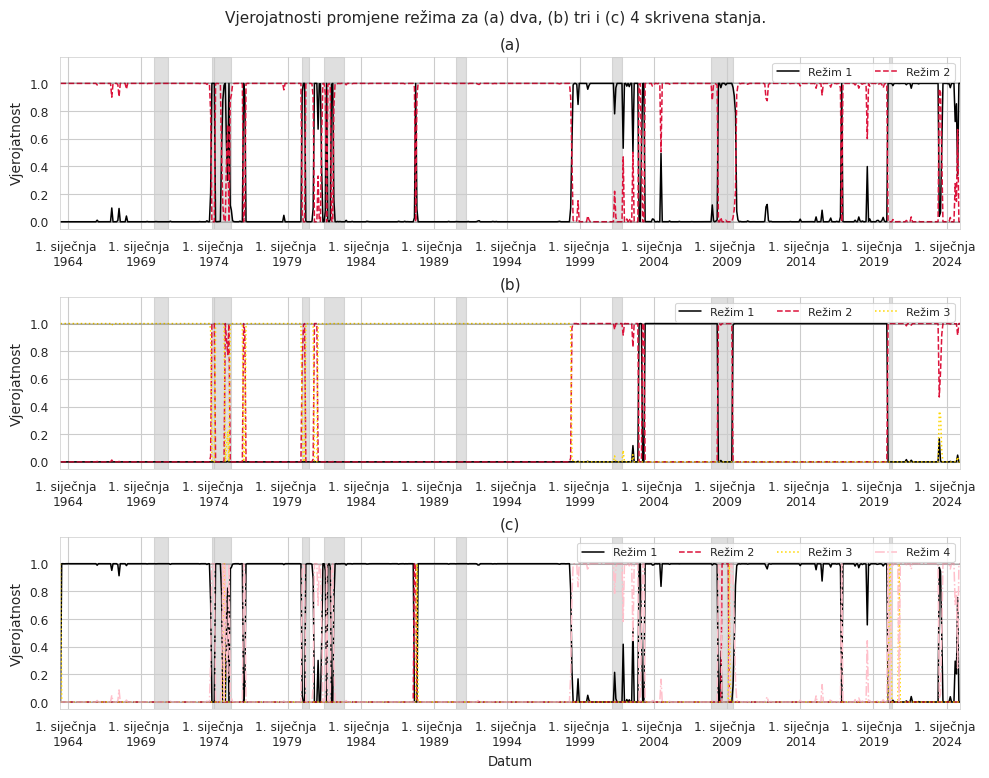

In [41]:
state_probs_list = [state_probs_2, state_probs_3, state_probs_4]
plot_regime_switches(
    model_parameters_df, state_probs_list, fred_recessions
)

In [42]:
def plot_means_by_state(h, model_parameters_df):
    """
    Plot the means of each feature for each hidden state in the HMM.
    Parameters:
        h (GaussianHMM): The trained HMM model.
        model_parameters_df (pd.DataFrame): DataFrame containing the model parameters.
    Returns:
        sns.FacetGrid: A seaborn FacetGrid object containing the bar plots.
    """
    means = h.means_
    n_components = h.n_components
    feature_names = model_parameters_df.columns
    n_features = len(feature_names)

    data_list = []
    for i in range(n_components):
        for j in range(n_features):
            data_list.append({
                "Skriveno stanje": f"Stanje {i}",
                "Faktor": feature_names[j],
                "Srednja vrijednost": means[i, j],
            })
    means_df = pd.DataFrame(data_list)

    y_min = means_df["Srednja vrijednost"].min()
    y_max = means_df["Srednja vrijednost"].max()

    aspect_ratio = 1.5
    base_fontsize = 10
    fontsize = max(6, base_fontsize - n_features / (5 * aspect_ratio))

    g = sns.catplot(
        data=means_df,
        x="Faktor",
        y="Srednja vrijednost",
        col="Skriveno stanje",
        kind="bar",
        col_wrap=2,
        height=5,
        aspect=aspect_ratio,
        sharex=False,
        sharey=False,
        edgecolor="black",
    )

    g.set_titles("Skriveno {col_name}")

    for ax in g.axes.flat:
        if not ax.has_data():
            continue
        ax.set_ylim(y_min - 0.1, y_max + 0.1)
        ax.set_xticks(np.arange(n_features))
        ax.set_xticklabels(feature_names, rotation=0, ha="center", fontsize=fontsize)

        ax.tick_params(axis="x", labelbottom=True)

        ax.grid(True, linestyle="--", alpha=0.7)

    g.set_axis_labels("Faktor", "Srednja vrijednost")
    g.figure.suptitle(f"Vektor očekivanja za model s {n_components} skrivena stanja.", y=1.02, fontsize=16)

    g.figure.tight_layout(pad=2.0)

    return g

In [43]:
def plot_stdev_by_state(h, model_parameters_df):
    """
    Plot the standard deviations of each feature for each hidden state in the HMM.
    Parameters:
        h (GaussianHMM): The trained HMM model.
        model_parameters_df (pd.DataFrame): DataFrame containing the model parameters.
    Returns:
        sns.FacetGrid: A seaborn FacetGrid object containing the bar plots.
    """
    covars_raw = h.covars_
    feature_names = model_parameters_df.columns

    variances = np.diagonal(covars_raw, axis1=1, axis2=2)

    stdevs = np.sqrt(np.maximum(variances, 0))
    n_components, n_features = stdevs.shape

    stdev_df = pd.DataFrame(
        {
            "Skriveno stanje": np.repeat(
                [f"Stanje {i}" for i in range(n_components)], n_features
            ),
            "Faktor": np.tile(feature_names, n_components),
            "Standardna devijacija": stdevs.ravel(),
        }
    )

    y_min = stdev_df["Standardna devijacija"].min()
    y_max = stdev_df["Standardna devijacija"].max()

    aspect_ratio = 1.5
    fontsize = max(6, 10 - n_features / (7.5))

    g = sns.catplot(
        data=stdev_df,
        x="Faktor",
        y="Standardna devijacija",
        col="Skriveno stanje",
        kind="bar",
        col_wrap=2,
        height=5,
        aspect=aspect_ratio,
        sharex=False,
        sharey=False,
        edgecolor="black",
    )

    g.set_titles("Skriveno {col_name}")

    for i, ax in enumerate(g.axes.flat):
        if i < n_components:
            ax.set_xticks(np.arange(n_features))
            ax.set_xticklabels(
                feature_names, rotation=0, ha="center", fontsize=fontsize
            )
            ax.tick_params(axis="x", labelbottom=True)
            ax.grid(True, linestyle="--", alpha=0.7)
            ax.set_ylim(y_min - 0.1, y_max + 0.1)

    g.set_axis_labels("Faktor", "Standardna devijacija")
    g.figure.suptitle(
        f"Standardne devijacije faktora za model s {n_components} skrivena stanja", y=1.02, fontsize=16
    )
    g.figure.tight_layout(pad=2.0)
    
    return g


In [44]:
def convert_to_correlation_matrix(covariance_matrix):
    """
    Convert a covariance matrix to a correlation matrix.
    Parameters:
        covariance_matrix (np.ndarray): The covariance matrix to convert.
    Returns:
        np.ndarray: The correlation matrix.
    """
    d = np.sqrt(np.diag(covariance_matrix))
    correlation_matrix = covariance_matrix / np.outer(d, d)
    return correlation_matrix

In [45]:
def plot_correlation_heatmaps(correlation_matrices, factor_names):
    """
    Plot heatmaps of correlation matrices for each hidden state.
    Parameters:
        correlation_matrices (list of np.ndarray): List of correlation matrices for each hidden state.
        factor_names (list of str): List of factor names corresponding to the correlation matrices.
    Returns:
        plt.Figure: The figure containing the heatmaps.
    """
    num_states = len(correlation_matrices)

    if num_states == 4:
        nrows, ncols = 2, 2
    elif num_states == 3:
        nrows, ncols = 1, 3
    elif num_states == 2:
        nrows, ncols = 1, 2
    else:
        nrows, ncols = 1, num_states

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes_flat = axes.flatten()

    plot_limit = num_states
    mask = np.triu(np.ones_like(correlation_matrices[0], dtype=bool))

    for i in range(plot_limit):
        ax = axes_flat[i]
        sns.heatmap(
            correlation_matrices[i],
            mask=mask,
            cmap="coolwarm",
            linewidths=0.5,
            ax=ax,
            xticklabels=factor_names,
            yticklabels=factor_names,
            vmin=-1,
            vmax=1,
            cbar=(i == ncols - 1) or (i == plot_limit - 1 and plot_limit % ncols != 0),
            cbar_kws={"label": "Korelacija"}
            if (i == ncols - 1) or (i == plot_limit - 1 and plot_limit % ncols != 0)
            else {},
            square=True,
        )
        ax.set_title(f"Stanje {i}")
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
        plt.setp(ax.get_yticklabels(), rotation=0, ha="right")


    for j in range(plot_limit, nrows * ncols):
        if j < len(axes_flat):
            fig.delaxes(axes_flat[j])

    fig.suptitle(f"Korelacijske matrice modela s {num_states} skrivenih stanja", fontsize=16, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig


In [46]:
def plot_transition_matrix(transmat, num_states):
    """
    Plot the transition matrix of the HMM.
    Parameters:
        transmat (np.ndarray): The transition matrix of the HMM.
        num_states (int): The number of hidden states in the HMM.
    Returns:
        plt.Figure: The figure containing the heatmap of the transition matrix.
    """
    fig, ax = plt.subplots()
    sns.heatmap(
        transmat,
        annot=True,
        cmap="coolwarm",
        fmt=".3f",
        linewidths=0.5,
        ax=ax,
        xticklabels=[f"Stanje {i}" for i in range(num_states)],
        yticklabels=[f"Stanje {i}" for i in range(num_states)],
    )
    ax.set_title("Matrica prijelaza između skrivenih stanja")
    plt.xlabel("Iduće stanje")
    plt.ylabel("Trenutno stanje")
    return fig

In [47]:
def run_model_analysis(model, model_parameters_df, dirname, fred_recessions, state_probs):
    """
    Run the model analysis for the given HMM model and save the figures to a directory.
    Parameters:
        model (GaussianHMM): The trained HMM model.
        model_parameters_df (pd.DataFrame): DataFrame containing the model parameters.
        dirname (str): Directory name to save the figures.
        fred_recessions (pd.DataFrame): DataFrame containing FRED recession dates.
        state_probs (np.ndarray): Array of state probabilities for each observation.

    Returns:
        str: Success message indicating the directory where figures were saved.
    """
    num_states = model.n_components
    dir = f"figures/{dirname}/{num_states}_states/"
    if not os.path.exists(dir):
        os.makedirs(dir)

    fig1 = plot_means_by_state(model, model_parameters_df)
    fig1.savefig(os.path.join(dir, "means_by_state.png"), dpi=300, bbox_inches='tight')
    plt.close(fig1.figure)

    fig2 = plot_stdev_by_state(model, model_parameters_df)
    fig2.savefig(os.path.join(dir, "stdev_by_state.png"), dpi=300, bbox_inches='tight')
    plt.close(fig2.figure)

    covariance_matrices = model.covars_
    correlation_matrices = []
    for matrix in covariance_matrices:
        correlation_matrix = convert_to_correlation_matrix(matrix)
        correlation_matrices.append(correlation_matrix)
    factor_names = model_parameters_df.columns.tolist()

    fig3 = plot_correlation_heatmaps(correlation_matrices, factor_names)
    fig3.savefig(os.path.join(dir, "correlation_heatmaps.png"), dpi=300, bbox_inches='tight')
    plt.close(fig3)

    fig4 = plot_transition_matrix(model.transmat_, num_states)
    fig4.savefig(os.path.join(dir, "transition_matrix.png"), dpi=300, bbox_inches='tight')
    plt.close(fig4)

    ax = plot_single_ax(
        state_probs=state_probs,
        time_index=model_parameters_df.index,
        n_regimes=num_states,
        fred_recessions=fred_recessions,
        title=f"Vjerojatnosti promjene režima za {num_states} skrivena stanja.",
    )
    fig5 = ax.get_figure()
    fig5.savefig(os.path.join(dir, "regime_probabilities.png"), dpi=300, bbox_inches='tight')
    plt.close(fig5)

    return "Successfully saved figures to directory:", dir


In [48]:
# for each state run the model analysis and save the graphs
for i,j in [(2, state_probs_2), (3, state_probs_3), (4, state_probs_4)]:
    run_model_analysis(best_models[i], model_parameters_df, dirname="state_analysis_full_timeframe", fred_recessions=fred_recessions, state_probs=j)

Iako model s 4 stanja ima najbolji AIC/BIC/LL score, analizom grafova koji predstavljaju model s 4 stanja naslućujemo da su 4 stanja previše i da su neka redundantna.
Pogledajmo grafove standardnih devijacija i očekivanih vrijednosti. Vidimo da su stanja 1 i dva gotovo ista po svim značajkama.
Pogledajmo nadalje matricu tranzicija, vidimo da postoji stanje koje nikada ne ostaje u samome sebi, tranizicjsko stanje u kojem je model najduže jedan trenutak, ovo nam govori da je vjerojatno redundantno za model.

Zbog navedenih razloga nastaviti ćemo s modelom s 2 stanja.

Slijedeći korak koji ćemo napraviti je treniranje HMM i provođenje regresije na periodu do 2010., a out-of-sample ćemo testirati na periodu od 2010. - 2024.

Proces će biti slijedeći: na periodu do 2010. ćemo fittati HMM model s 2 stanja. Naći ćemo model s najboljim LL i njega uzeti za predviđanje vjerojatnosti da smo u stanju 1 ili 2. Iz danog modela izvaditi ćemo prije spomenute vjerojatnosti i means od faktora. Kako bismo izračunali očekivani povrat s faktorskim modelom moramo provesti regresiju. Provesti ćemo ju do istog perioda do kada fittamo HMM model. Izračunati ćemo očekivani povrat svakog od 100 portfelja i uzeti onaj s najboljim Sharpe ratiom. Parametre HMM modela i regresije updateati ćemo svaki mjesec za početak.

In [49]:
def time_series_train_test_split(
    df,
    end_date,
    start_date=None,
    offset_kwargs=None
):
    """
    Splits a single DataFrame into training and testing sets based on a specified end date.

    Parameters:
        df (pd.DataFrame): The DataFrame to split. Must have a DateTime index.
        end_date (str or pd.Timestamp): The last date to include in the training set.
        start_date (str or pd.Timestamp, optional): The first date to include in the training set. Defaults to the earliest date in df.
        offset_kwargs (dict, optional): Arguments for pd.DateOffset to determine the start of the test set. Defaults to {'months': 1}.

    Returns:
        (pd.DataFrame, pd.DataFrame): The train and test splits.
    """
    if offset_kwargs is None:
        offset_kwargs = {'months': 1}
    if start_date is None:
        start_date = df.index.min()
    train_split = df.loc[start_date:end_date]
    test_start = pd.to_datetime(end_date) + pd.DateOffset(**offset_kwargs)
    test_split = df.loc[test_start:]
    return train_split, test_split


In [50]:
train, test = time_series_train_test_split(
    model_parameters_df,
    start_date="1963-07-01",
    end_date="2009-12-01"
)
hmm_train = train
hmm_test = test

In [51]:
# fit the HMM model on the training data only
aic_train, bic_train, lls_train, convergence_status_train, iterations_train, best_models_train, models_train = evaluate_hmm(
    hmm_train, rs, [2], loop=200
)
hmm_train_model = best_models_train[2]
state_probs_train = hmm_train_model.predict_proba(hmm_train.values, lengths=len(hmm_train))

Model is not converging.  Current: -20240.674013925207 is not greater than -20042.751865385853. Delta is -197.92214853935366


Convergence Status:  [True]
Iterations:  [30]


In [52]:
# run the analysis on the training model
run_model_analysis(
    hmm_train_model, hmm_train, dirname="state_analysis_train_model", fred_recessions=fred_recessions, state_probs=state_probs_train
)

('Successfully saved figures to directory:',
 'figures/state_analysis_train_model/2_states/')

In [53]:
def max_sharpe_portfolio(mean_returns, cov_matrix):
    """
    Calculate the weights of the portfolio that maximizes the Sharpe ratio.

    Parameters:
        mean_returns (np.ndarray): Expected returns of the assets.
        cov_matrix (np.ndarray): Covariance matrix of the asset returns.
        
    Returns:
        tuple: A tuple containing the optimal weights and the maximum Sharpe ratio.
    """
    n = len(mean_returns)
    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
        return -port_return / port_vol

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = tuple((0, 1) for _ in range(n))
    x0 = np.ones(n) / n

    result = minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    if not result.success:
        raise ValueError("Optimization failed:", result.message)
    return result.x, -result.fun * np.sqrt(12)

The covariance of two random variables is the mean of the conditional covariances plus the covariance of the conditional means.

https://math.stackexchange.com/a/195934

In [54]:
%%capture --no-display

rebalance_retrain_mapping = {
    "monthly": {"rebalance_freq": 1, "retrain_freq": 6},
    "quarterly": {"rebalance_freq": 3, "retrain_freq": 6},
    "semiannually": {"rebalance_freq": 6, "retrain_freq": 12}
}

lookback = 12  # months
multistep = 6  # months


# Dictionaries to store results for each frequency
results_dict = {}
results_multistep_dict = {}
portfolio_returns_dict = {}
multistep_portfolio_returns_dict = {}
benchmark_equal_weights_dict = {}
benchmark_optimal_weights_dict = {}

for freq_name, mapping in rebalance_retrain_mapping.items():
    rebalance_freq = mapping["rebalance_freq"]
    retrain_freq = mapping["retrain_freq"]

    # Re-initialize for each frequency
    hmm_train_copy = hmm_train.copy()
    hmm_test_copy = hmm_test.copy()
    hmm_model = hmm_train_model  # initial model

    # Initialize lists instead of empty DataFrames
    results_list = []
    results_multistep_list = []
    portfolio_returns_list = []
    multistep_portfolio_returns_list = []
    benchmark_equal_weights_list = []
    benchmark_optimal_weights_list = []

    iteration = 0
    while len(hmm_test_copy) > 0:
        current_date = hmm_test_copy.index[0]

        lookback_start = current_date - pd.DateOffset(months=lookback)
        mask = (hmm_train_copy.index >= lookback_start) & (hmm_train_copy.index < current_date)
        lookback_period_data = hmm_train_copy.loc[mask]

        # Refit model at rebalance points (except first iteration)
        if iteration % retrain_freq == 0 and iteration != 0:
            _, _, _, _, _, best_models, _ = evaluate_hmm(hmm_train_copy, rs, [2], loop=200)
            hmm_model = best_models[2]

        # Probabilities for current date
        probabilities = hmm_model.predict_proba(lookback_period_data.values, lengths=len(lookback_period_data))
        current_date_probs = probabilities[-1]

        # State means and covariances
        state_means = hmm_model.means_
        state_covars = hmm_model.covars_

        # -- Single-step prediction --
        means_vector = np.dot(current_date_probs, state_means)
        n = len(hmm_test_copy.columns)
        covars_vector = np.zeros((n, n))
        for i in range(len(current_date_probs)):
            mean_diff = state_means[i] - means_vector
            covars_vector += current_date_probs[i] * (np.outer(mean_diff, mean_diff) + state_covars[i])

        # Append factor predictions to list
        new_row = pd.DataFrame({
            "Predicted Vector": [means_vector],
            "Actual Vector": [hmm_test_copy.loc[current_date].values]
        }, index=[current_date])
        results_list.append(new_row)

        # -- Multi-step prediction --
        multi_step_probs = current_date_probs.copy()
        for _ in range(multistep):
            multi_step_probs = np.dot(multi_step_probs, hmm_model.transmat_)
        means_vector_multistep = np.dot(multi_step_probs, state_means)
        covars_vector_multistep = np.zeros((n, n))
        for i in range(len(multi_step_probs)):
            mean_diff = state_means[i] - means_vector_multistep
            covars_vector_multistep += multi_step_probs[i] * (np.outer(mean_diff, mean_diff) + state_covars[i])

        multi_step_date = current_date + pd.DateOffset(months=multistep)
        if multi_step_date in hmm_test_copy.index:
            actual_vector_multistep = hmm_test_copy.loc[multi_step_date].values
        else:
            actual_vector_multistep = np.nan * np.ones(len(hmm_test_copy.columns))

        new_row_multistep = pd.DataFrame({
            "Predicted Vector": [means_vector_multistep],
            "Actual Vector": [actual_vector_multistep]
        }, index=[multi_step_date])
        results_multistep_list.append(new_row_multistep)

        # -- Benchmark prediction --
        benchmark_means_vector = hmm_train_copy.iloc[-lookback:].mean().values
        benchmark_covars_vector = hmm_train_copy.iloc[-lookback:].cov().values

        # -- Portfolio optimization --
        benchmark_weights_equal = np.ones(len(hmm_test_copy.columns)) / len(hmm_test_copy.columns)

        if iteration % rebalance_freq == 0 or iteration == 0:
            weights, sharpe = max_sharpe_portfolio(means_vector, covars_vector)
            weights_multistep, sharpe_multistep = max_sharpe_portfolio(means_vector_multistep, covars_vector_multistep)
            benchmark_weights_optimal, benchmark_sharpe = max_sharpe_portfolio(benchmark_means_vector, benchmark_covars_vector)

        # -- Benchmark returns --
        benchmark_equal_weights_return = np.dot(benchmark_weights_equal, hmm_test_copy.loc[current_date].values)
        benchmark_optimal_weights_return = np.dot(benchmark_weights_optimal, hmm_test_copy.loc[current_date].values)

        new_row_benchmark_equal = pd.DataFrame({
            "Benchmark Equal Weights Return": [benchmark_equal_weights_return],
            "Weights": [benchmark_weights_equal],
            "Sharpe Ratio": [np.nan]
        }, index=[current_date])
        benchmark_equal_weights_list.append(new_row_benchmark_equal)

        new_row_benchmark_optimal = pd.DataFrame({
            "Benchmark Optimal Weights Return": [benchmark_optimal_weights_return],
            "Weights": [benchmark_weights_optimal],
            "Sharpe Ratio": [benchmark_sharpe]
        }, index=[current_date])
        benchmark_optimal_weights_list.append(new_row_benchmark_optimal)

        # -- Portfolio returns --
        factor_returns = np.dot(weights, hmm_test_copy.loc[current_date].values)
        new_row_portfolio = pd.DataFrame({
            "Portfolio Return": [factor_returns],
            "Weights": [weights],
            "Sharpe Ratio": [sharpe]
        }, index=[current_date])
        portfolio_returns_list.append(new_row_portfolio)

        # -- Multi-step portfolio returns --
        if multi_step_date in hmm_test_copy.index:
            factor_returns_multistep = np.dot(weights_multistep, hmm_test_copy.loc[multi_step_date].values)
        else:
            factor_returns_multistep = np.nan

        new_row_portfolio_multistep = pd.DataFrame({
            "Portfolio Return": [factor_returns_multistep],
            "Weights": [weights_multistep],
            "Sharpe Ratio": [sharpe_multistep]
        }, index=[multi_step_date])
        multistep_portfolio_returns_list.append(new_row_portfolio_multistep)


        # Move forward a month
        hmm_train_copy = pd.concat([hmm_train_copy, hmm_test_copy.iloc[:1]], ignore_index=False).sort_index()
        hmm_test_copy = hmm_test_copy.iloc[1:].sort_index()
        iteration += 1

    # Concatenate all collected data at once for this frequency
    results_df = pd.concat(results_list, ignore_index=False) if results_list else pd.DataFrame(columns=["Predicted Vector", "Actual Vector"])
    results_multistep_df = pd.concat(results_multistep_list, ignore_index=False) if results_multistep_list else pd.DataFrame(columns=["Predicted Vector", "Actual Vector"])
    portfolio_returns = pd.concat(portfolio_returns_list, ignore_index=False) if portfolio_returns_list else pd.DataFrame(columns=["Portfolio Return", "Weights", "Sharpe Ratio"])
    multistep_portfolio_returns = pd.concat(multistep_portfolio_returns_list, ignore_index=False) if multistep_portfolio_returns_list else pd.DataFrame(columns=["Portfolio Return", "Weights", "Sharpe Ratio"])
    benchmark_equal_weights = pd.concat(benchmark_equal_weights_list, ignore_index=False) if benchmark_equal_weights_list else pd.DataFrame(columns=["Benchmark Equal Weights Return", "Weights", "Sharpe Ratio"])
    benchmark_optimal_weights = pd.concat(benchmark_optimal_weights_list, ignore_index=False) if benchmark_optimal_weights_list else pd.DataFrame(columns=["Benchmark Optimal Weights Return", "Weights", "Sharpe Ratio"])

    # Store results for this frequency
    results_dict[freq_name] = results_df
    results_multistep_dict[freq_name] = results_multistep_df
    portfolio_returns_dict[freq_name] = portfolio_returns
    multistep_portfolio_returns_dict[freq_name] = multistep_portfolio_returns
    benchmark_equal_weights_dict[freq_name] = benchmark_equal_weights
    benchmark_optimal_weights_dict[freq_name] = benchmark_optimal_weights

# Example: Access monthly results
# results_dict['monthly'], portfolio_returns_dict['monthly']


In [55]:
def mean_directional_accuracy(predicted, actual):
    """
    Mean directional accuracy metric to evaluate the performance of predicted returns against actual returns.
    Calculated as the proportion of times the predicted direction matches the actual direction.
    
    Parameters:
        predicted (np.ndarray): Predicted returns.
        actual (np.ndarray): Actual returns.
    Returns:
        float: Mean directional accuracy
    """
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)

    num_correct = np.sum(actual_signs == predicted_signs)
    return num_correct / (len(actual) - 1)

In [56]:
# Statistics to evaluate results

for freq_name in results_dict:
    print(f"\n===== {freq_name.upper()} REBALANCE =====")
    
    # Get results for current freq
    results_df = results_dict[freq_name]
    results_multistep_df = results_multistep_dict[freq_name]
    
    # Single-step evaluation
    actual_vectors = np.array(results_df["Actual Vector"].tolist())
    predicted_vectors = np.array(results_df["Predicted Vector"].tolist())
    
    actual_flat = actual_vectors.flatten()
    predicted_flat = predicted_vectors.flatten()
    
    r2 = r2_score(actual_flat, predicted_flat)

    print(f"R^2 Score for the predicted vs actual vectors: {r2:.4f}")
    print(f"Mean Directional Accuracy: {mean_directional_accuracy(predicted_flat, actual_flat):.4f}")
    spearman_corr, _ = spearmanr(actual_flat, predicted_flat)
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print()
    
    # Multi-step evaluation
    results_multistep_df_copy = results_multistep_df[:-6]
    actual_vectors_multistep = np.array(results_multistep_df_copy["Actual Vector"].tolist()).flatten()
    predicted_vectors_multistep = np.array(results_multistep_df_copy["Predicted Vector"].tolist()).flatten()
    
    r2_multistep = r2_score(actual_vectors_multistep, predicted_vectors_multistep)
    print(f"R^2 Score for the multi-step predicted vs actual vectors: {r2_multistep:.4f}")
    print(f"Mean Directional Accuracy (multi-step): {mean_directional_accuracy(predicted_vectors_multistep, actual_vectors_multistep):.4f}")
    spearman_corr_multistep, _ = spearmanr(actual_vectors_multistep, predicted_vectors_multistep)
    print(f"Spearman Correlation (multi-step): {spearman_corr_multistep:.4f}")


===== MONTHLY REBALANCE =====
R^2 Score for the predicted vs actual vectors: -0.0126
Mean Directional Accuracy: 0.5009
Spearman Correlation: 0.0260

R^2 Score for the multi-step predicted vs actual vectors: 0.0060
Mean Directional Accuracy (multi-step): 0.5023
Spearman Correlation (multi-step): 0.1233

===== QUARTERLY REBALANCE =====
R^2 Score for the predicted vs actual vectors: -0.0125
Mean Directional Accuracy: 0.5009
Spearman Correlation: 0.0260

R^2 Score for the multi-step predicted vs actual vectors: 0.0060
Mean Directional Accuracy (multi-step): 0.5023
Spearman Correlation (multi-step): 0.1233

===== SEMIANNUALLY REBALANCE =====
R^2 Score for the predicted vs actual vectors: -0.0113
Mean Directional Accuracy: 0.4946
Spearman Correlation: 0.0208

R^2 Score for the multi-step predicted vs actual vectors: 0.0068
Mean Directional Accuracy (multi-step): 0.5031
Spearman Correlation (multi-step): 0.1292


In [57]:
def stacked_area_plot(weights_df, title="Portfolio Weights Over Time"):
    palette = sns.color_palette("husl", n_colors=len(weights_df.columns))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.stackplot(
        weights_df.index,
        weights_df.T.values,
        labels=weights_df.columns,
        alpha=0.8,
        edgecolor="black",
        colors=palette,
    )
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Weight")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Factors")
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()


===== MONTHLY REBALANCE PORTFOLIO WEIGHTS =====


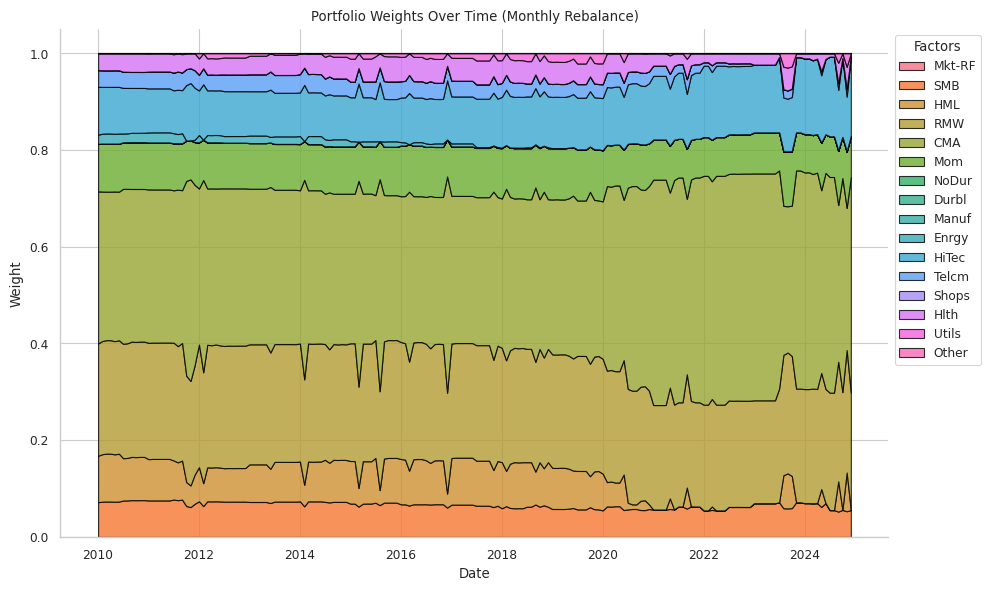

Last Weights:
Mkt-RF (%)    0.00
SMB (%)       5.54
HML (%)       0.00
RMW (%)      24.28
CMA (%)      44.61
Mom (%)       8.39
NoDur (%)     0.00
Durbl (%)     0.00
Manuf (%)     0.00
Enrgy (%)     0.00
HiTec (%)    16.47
Telcm (%)     0.00
Shops (%)     0.00
Hlth (%)      0.71
Utils (%)     0.00
Other (%)     0.00

===== QUARTERLY REBALANCE PORTFOLIO WEIGHTS =====


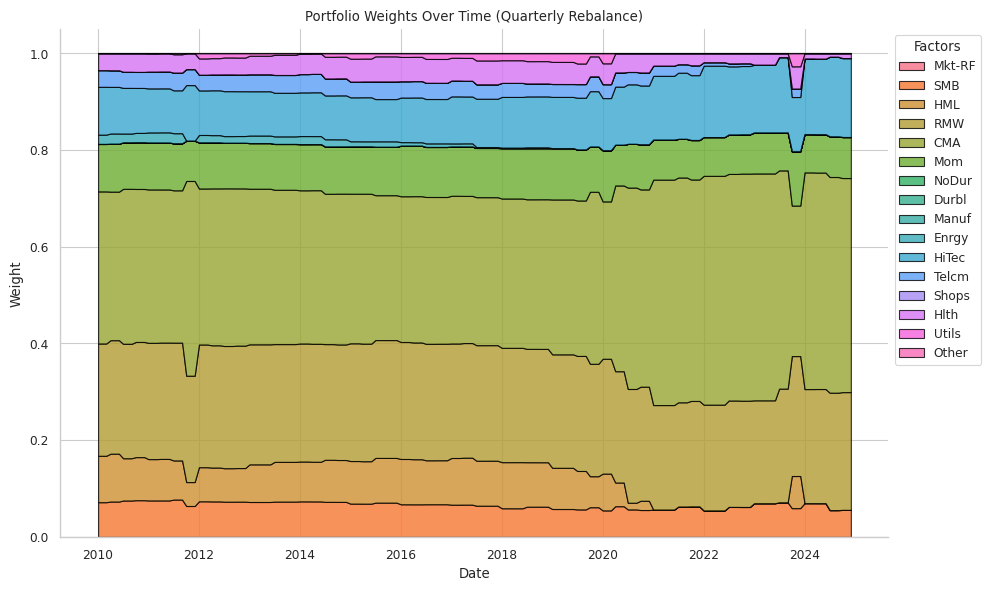

Last Weights:
Mkt-RF (%)    0.00
SMB (%)       5.58
HML (%)       0.00
RMW (%)      24.36
CMA (%)      44.27
Mom (%)       8.48
NoDur (%)     0.00
Durbl (%)     0.00
Manuf (%)     0.00
Enrgy (%)     0.00
HiTec (%)    16.33
Telcm (%)     0.00
Shops (%)     0.00
Hlth (%)      0.98
Utils (%)     0.00
Other (%)     0.00

===== SEMIANNUALLY REBALANCE PORTFOLIO WEIGHTS =====


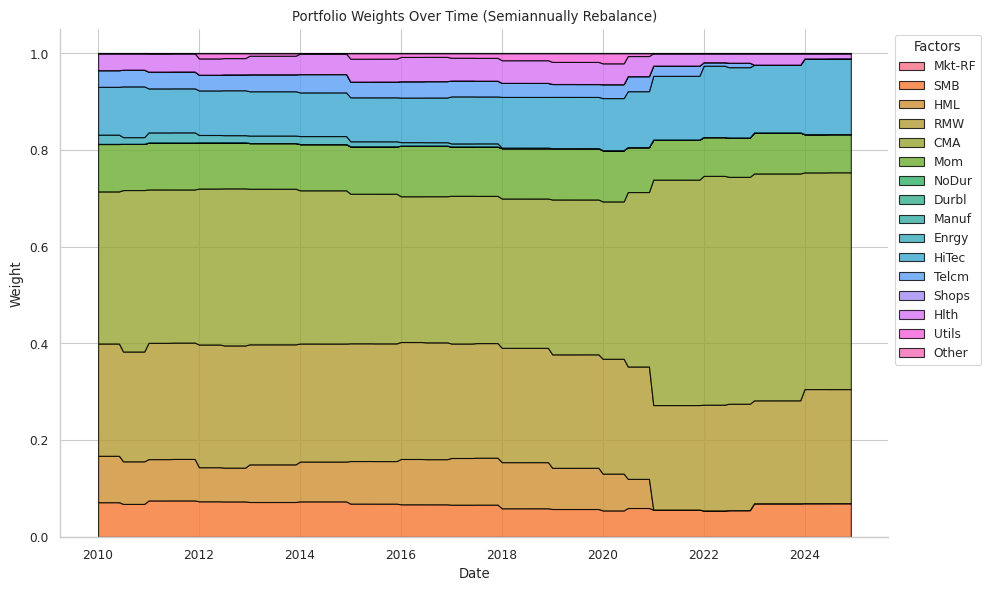

Last Weights:
Mkt-RF (%)    0.00
SMB (%)       6.98
HML (%)       0.00
RMW (%)      23.59
CMA (%)      44.83
Mom (%)       7.90
NoDur (%)     0.00
Durbl (%)     0.00
Manuf (%)     0.00
Enrgy (%)     0.00
HiTec (%)    15.65
Telcm (%)     0.00
Shops (%)     0.00
Hlth (%)      1.06
Utils (%)     0.00
Other (%)     0.00


In [58]:
for freq_name in multistep_portfolio_returns_dict:
    print(f"\n===== {freq_name.upper()} REBALANCE PORTFOLIO WEIGHTS =====")
    
    weights_df = pd.DataFrame(
    [weights for weights in multistep_portfolio_returns_dict[freq_name]["Weights"]],
    index=portfolio_returns.index,
    columns=hmm_train.columns
)
    
    stacked_area_plot(weights_df, 
                      title=f"Portfolio Weights Over Time ({freq_name.capitalize()} Rebalance)")


    portfolio_weights_percent = weights_df.apply(lambda x: x * 100).round(2)
    portfolio_weights_percent.columns = [f"{col} (%)" for col in portfolio_weights_percent.columns]

    print("Last Weights:")
    print(portfolio_weights_percent.iloc[-1].to_string(index=True, float_format="{:.2f}".format))

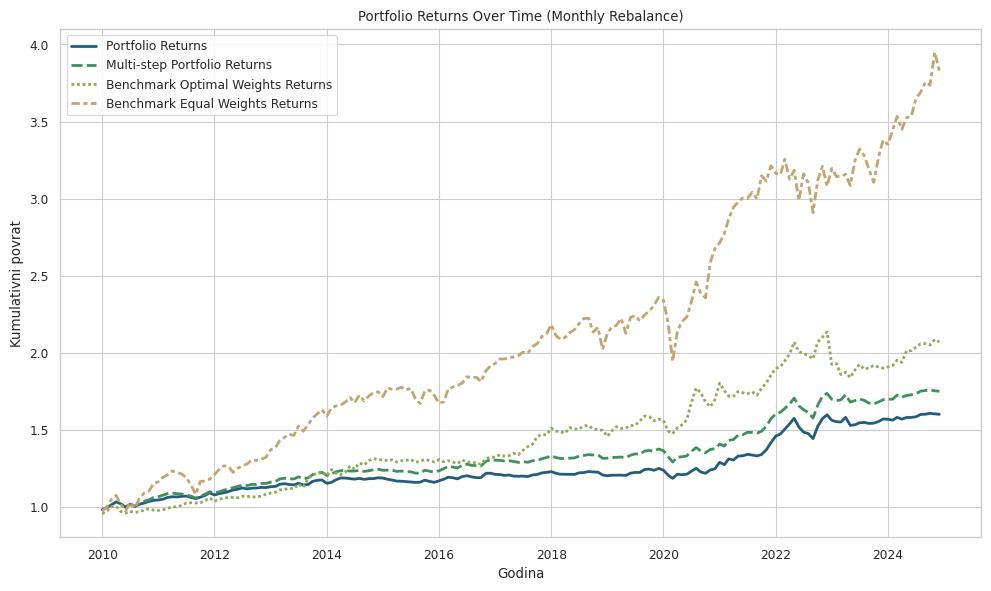

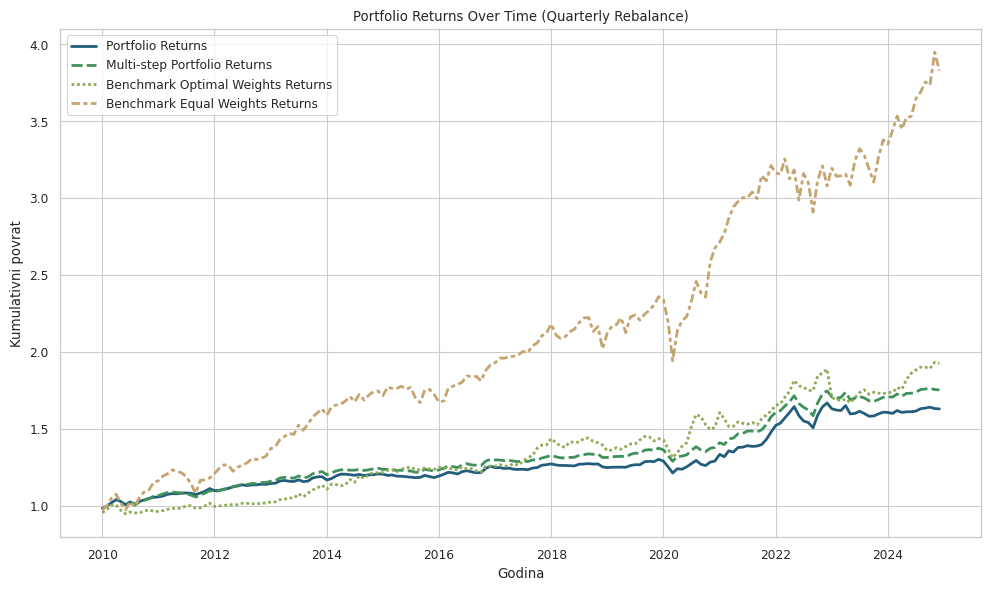

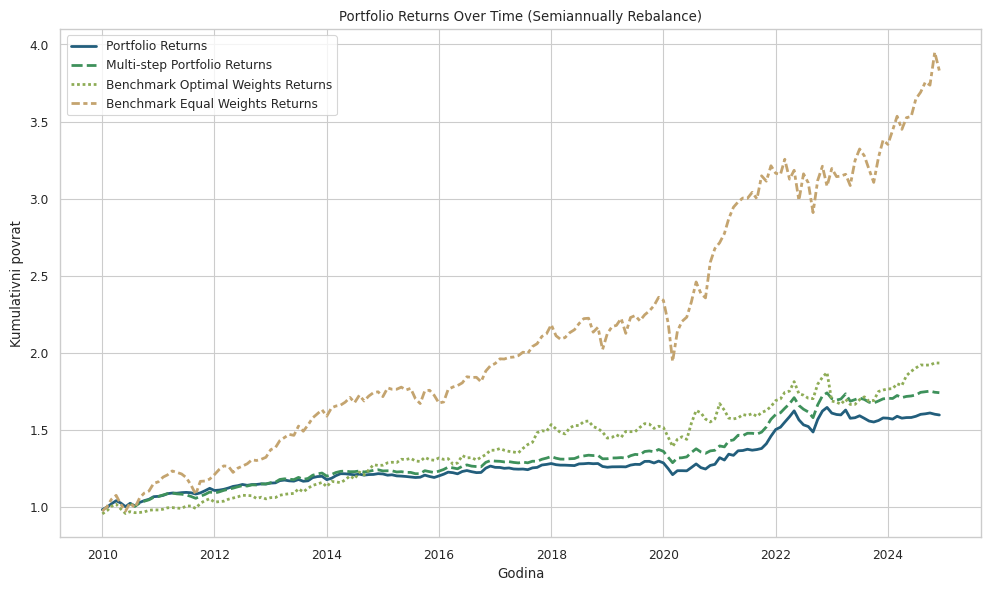

In [59]:
for freq_name in portfolio_returns_dict:
    plottable_df = []
    portfolio_returns = portfolio_returns_dict[freq_name]["Portfolio Return"] / 100
    multistep_portfolio_returns = multistep_portfolio_returns_dict[freq_name]["Portfolio Return"] / 100
    benchmark_portfolio_returns = benchmark_optimal_weights_dict[freq_name]["Benchmark Optimal Weights Return"] / 100
    benchmark_equal_weights = benchmark_equal_weights_dict[freq_name]["Benchmark Equal Weights Return"] / 100
    
    plottable_df.append(
        pd.DataFrame({
            "Portfolio Returns": portfolio_returns,
            "Multi-step Portfolio Returns": multistep_portfolio_returns,
            "Benchmark Optimal Weights Returns": benchmark_portfolio_returns,
            "Benchmark Equal Weights Returns": benchmark_equal_weights
        }, index=portfolio_returns.index)
    )
    plottable_df = pd.concat(plottable_df, axis=1)
    plot_cumulative_returns(plottable_df, title=f"Portfolio Returns Over Time ({freq_name.capitalize()} Rebalance)")   

In [60]:
for freq_name in portfolio_returns_dict:
    print(f"\n===== {freq_name.upper()} REBALANCE SHARPE RATIOS =====")
    
    portfolio_returns = portfolio_returns_dict[freq_name]["Portfolio Return"]
    benchmark_returns = benchmark_optimal_weights_dict[freq_name]["Benchmark Optimal Weights Return"]
    benchmark_equal_weights = benchmark_equal_weights_dict[freq_name]["Benchmark Equal Weights Return"]
    multistep_portfolio_returns = multistep_portfolio_returns_dict[freq_name]["Portfolio Return"]
    
    port_sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(12)
    multistep_portfolio_sharpe = multistep_portfolio_returns.mean() / multistep_portfolio_returns.std() * np.sqrt(12)
    benchmark_sharpe = benchmark_returns.mean() / benchmark_returns.std() * np.sqrt(12)
    benchmark_equal_weights_sharpe = benchmark_equal_weights.mean() / benchmark_equal_weights.std() * np.sqrt(12)
    
    print(f"Portfolio Sharpe Ratio: {port_sharpe:.4f}")
    print(f"Multi-step Portfolio Sharpe Ratio: {multistep_portfolio_sharpe:.4f}")
    print(f"Benchmark MVO Sharpe Ratio: {benchmark_sharpe:.4f}")
    print(f"Benchmark Equal Weights Sharpe Ratio: {benchmark_equal_weights_sharpe:.4f}")



===== MONTHLY REBALANCE SHARPE RATIOS =====
Portfolio Sharpe Ratio: 0.7784
Multi-step Portfolio Sharpe Ratio: 0.9971
Benchmark MVO Sharpe Ratio: 0.7486
Benchmark Equal Weights Sharpe Ratio: 0.9123

===== QUARTERLY REBALANCE SHARPE RATIOS =====
Portfolio Sharpe Ratio: 0.7857
Multi-step Portfolio Sharpe Ratio: 1.0008
Benchmark MVO Sharpe Ratio: 0.6863
Benchmark Equal Weights Sharpe Ratio: 0.9123

===== SEMIANNUALLY REBALANCE SHARPE RATIOS =====
Portfolio Sharpe Ratio: 0.7401
Multi-step Portfolio Sharpe Ratio: 0.9912
Benchmark MVO Sharpe Ratio: 0.6683
Benchmark Equal Weights Sharpe Ratio: 0.9123


pretpostavljam da ću idućih 6 mjeseci biti u nekom od dva stanja po vjerojatnostima danima od predikcije na temelju zadnjih godinu dana, propagirano po tranizicjskoj matrici iztreniranog modela na cijelom trening periodu

stacked area plot za težine - done 

benchmark mvo gdje je procjena sredine i kovarinace na povijensnom prozoru, na povijesnih 12 mjeseci izračunat mvo portfelj
na svakom koraku
equal weighted isto za usporedbu
sample mean variance
hmm
rebalans svaki mjesec vs 6 mjeseci vs godinu dana - done

bonus:
prema faktorskog modela

Metodologija prvo, varijable, odakle dolazi
kreni od HMM
fama french
objasni HMM
primjena na financijske vremenske nizove, ekspirementalni setup dokad train itd
kako se uči
primjena na MVO
optimizacijski portfelj, sharpe std mean 

da znam sve o tome i reproducirat


poglavlje rezultata
statistika, portfeli tablice, grafovi

notacija